# Project: Road Accidents in France based on Annual Road Traffic Accident Injury Database (2005 - 2023)

## Step 2: Baseline Models - 3-Class

Import required libraries and load the cleaned dataset containing accident records

In [6]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & feature engineering
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight

In [7]:
file_path = "../data/processed/df_for_ml.csv"
df = pd.read_csv(file_path, low_memory=False)

In [8]:
# Convert to 'category' dtype
category_columns = [
    'lum', 'int', 'atm', 'col', 'circ', 'vosp', 'prof', 'plan', 'surf',
    'infra', 'situ', 'senc', 'obs', 'obsm', 'choc', 'catu', 'grav', 'sexe',
    'dayofweek', 'belt_status', 'agg_catr', 'catv_group', 'rush_hour',
    'season', 'age_bin', 'belt_user_type_code'
]

for col in category_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Convert to nullable integers (Int64)
nullable_int_columns = ['nbv', 'age']
for col in nullable_int_columns:
    if col in df.columns:
        df[col] = df[col].astype('Int64')

# Leave 'hour' as standard integer
if 'hour' in df.columns:
    df['hour'] = df['hour'].astype('int64')

print(df.dtypes)

lum                    category
int                    category
atm                    category
col                    category
circ                   category
nbv                       Int64
vosp                   category
prof                   category
plan                   category
surf                   category
infra                  category
situ                   category
senc                   category
obs                    category
obsm                   category
choc                   category
catu                   category
grav                   category
sexe                   category
hour                      int64
dayofweek              category
belt_status            category
age                       Int64
agg_catr               category
catv_group             category
rush_hour              category
season                 category
age_bin                category
belt_user_type_code    category
dtype: object


In [17]:
# ----- PARAMETERS -----
use_full_data = False  # Set to True to use the full dataset
sample_fraction = 0.2  # 20% of the data

In [19]:
# ----- LABEL PROCESSING -----

# New 3-class mapping: Hospitalized, Killed, Minor/None
grav_mapping = {
    1: "Minor/None",      # Unharmed
    2: "Killed",
    3: "Hospitalized",
    4: "Minor/None"       # Light injury
}
df["grav_label"] = df["grav"].map(grav_mapping)

# Optional sampling
if not use_full_data:
    df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)

# Encode target
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(df["grav_label"]))
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Drop label columns from input
X = df.drop(columns=["grav", "grav_label"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Detect feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()

# Distribution check
print("Class distribution:\n", y.value_counts(normalize=True).sort_index())
print("Class mapping:", class_mapping)

Class distribution:
 0    0.139253
1    0.016668
2    0.844079
Name: proportion, dtype: float64
Class mapping: {'Hospitalized': 0, 'Killed': 1, 'Minor/None': 2}


#### Test of Feature Selection with `VarianceThreshold`

After one-hot encoding, we applied: `VarianceThreshold(threshold=0.05)` to remove low-variance (mostly zero) features and to reduce noise and overfitting

##### Test on 50% of data
- **Before:** 155 features  
- **After:** 78 features  

In [22]:
# 🧪 Sample 50% of training data
sample_frac = 0.5
X_sample = X_train.sample(frac=sample_frac, random_state=42)

# Select categorical columns only
X_cat = X_sample[categorical_features]

# Encode without VarianceThreshold
pipeline_no_thresh = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
X_encoded = pipeline_no_thresh.fit_transform(X_cat)
print(f"🔢 One-hot encoded feature count (before VarianceThreshold): {X_encoded.shape[1]}")

# Encode with VarianceThreshold
pipeline_with_thresh = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ("varthresh", VarianceThreshold(threshold=0.05))
])
X_filtered = pipeline_with_thresh.fit_transform(X_cat)
print(f"✅ Feature count after VarianceThreshold: {X_filtered.shape[1]}")

🔢 One-hot encoded feature count (before VarianceThreshold): 155
✅ Feature count after VarianceThreshold: 78


In [24]:
# Preprocessor pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
        ("varthresh", VarianceThreshold(threshold=0.05))
    ]), categorical_features)
])

## Models and Evaluation

### Model Evaluation

Each model is trained and evaluated using:

- **Stratified 80/20 train-test split**
- **Pipeline-based preprocessing**
- **Metrics**:
  - Accuracy
  - Precision
  - Recall
  - F1-score (`classification_report`)
- **Cross-validation** (`GridSearchCV`) for logistic regression and decision tree, using macro-averaged F1 score to handle class imbalance.

This setup ensures a fair comparison and robust performance assessment while avoiding data leakage and overfitting.


# Accident Severity Models (3-Class)


### Baseline models

We test three classifiers to evaluate baseline and benchmark performance:

#### 1. **Dummy Classifier**
- **Type**: Baseline
- **What it does**: Always predicts the most frequent class.
- **Why**: Sets a naive baseline — all real models must outperform this.
- **Parameters**:
  - `strategy='most_frequent'`

#### 2. **Logistic Regression** *(with Grid Search)*
- **Type**: Linear classifier
- **What it does**: Learns a linear decision boundary.
- **Why**: Fast, interpretable, and strong as a first benchmark.
- **Tuned Parameters**:
  - `C`: Regularization strength (`[0.1, 1.0, 10.0]`)
  - `penalty`: `'l2'`
- **Fixed Parameters**:
  - `max_iter=1000`
  - `class_weight='balanced'`: Compensates for class imbalance.

#### 3. **Decision Tree Classifier** *(with Grid Search)*
- **Type**: Non-linear classifier
- **What it does**: Learns decision rules by recursive feature splitting.
- **Why**: Captures interactions and non-linear patterns.
- **Tuned Parameters**:
  - `max_depth`: `[5, 10, 20, None]`
  - `min_samples_split`: `[2, 5, 10]`
- **Fixed Parameters**:
  - `random_state=42`
  - `class_weight='balanced'`


🔍 Tuning model: Dummy_3class_Hospitalized_Killed_Minor-None
Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Best parameters for Dummy_3class_Hospitalized_Killed_Minor-None: {}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6143
           1       0.00      0.00      0.00       735
           2       0.84      1.00      0.92     37232

    accuracy                           0.84     44110
   macro avg       0.28      0.33      0.31     44110
weighted avg       0.71      0.84      0.77     44110



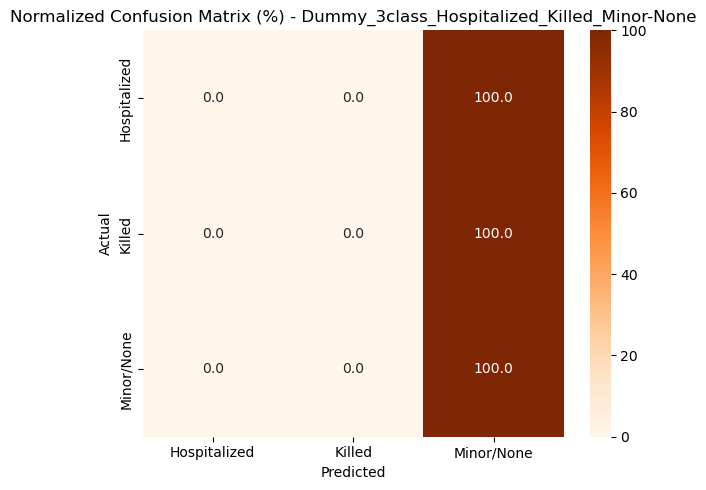


🔍 Tuning model: Logistic Regression_3class_Hospitalized_Killed_Minor-None
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✅ Best parameters for Logistic Regression_3class_Hospitalized_Killed_Minor-None: {'classifier__C': 10.0, 'classifier__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.37      0.25      0.30      6143
           1       0.11      0.40      0.17       735
           2       0.90      0.90      0.90     37232

    accuracy                           0.80     44110
   macro avg       0.46      0.52      0.46     44110
weighted avg       0.81      0.80      0.80     44110



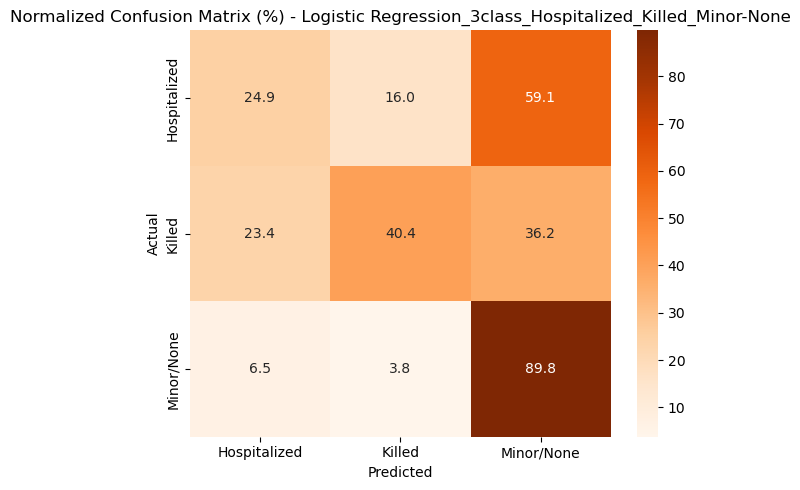


🔍 Tuning model: Decision Tree_3class_Hospitalized_Killed_Minor-None
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Best parameters for Decision Tree_3class_Hospitalized_Killed_Minor-None: {'classifier__max_depth': None, 'classifier__min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.29      0.38      0.33      6143
           1       0.12      0.19      0.15       735
           2       0.89      0.84      0.87     37232

    accuracy                           0.77     44110
   macro avg       0.44      0.47      0.45     44110
weighted avg       0.80      0.77      0.78     44110



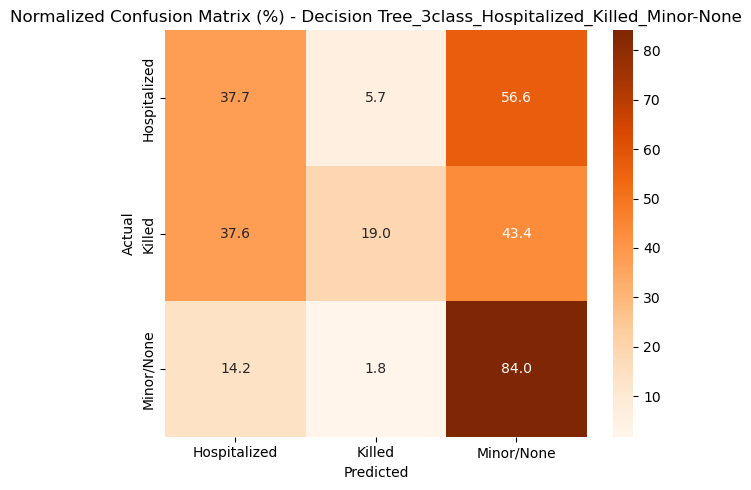

In [26]:
# Define models
models = {
    "Dummy_3class_Hospitalized_Killed_Minor-None": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression_3class_Hospitalized_Killed_Minor-None": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    "Decision Tree_3class_Hospitalized_Killed_Minor-None": DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

# Hyperparameter grids
param_grids = {
    "Dummy_3class_Hospitalized_Killed_Minor-None": {},
    "Logistic Regression_3class_Hospitalized_Killed_Minor-None": {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l2']
    },
    "Decision Tree_3class_Hospitalized_Killed_Minor-None": {
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# Evaluation labels
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}

# Train and evaluate
for name, model in models.items():
    print(f"\n🔍 Tuning model: {name}")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        scoring='f1_macro',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)

    # Evaluation
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

    results[name] = {
        "model_name": name,
        "best_params": search.best_params_,
        "classification_report": report_dict,
        "confusion_matrix": cm.tolist(),
        "confusion_matrix_percent": cm_percent.tolist()
    }

    print(f"\n✅ Best parameters for {name}: {search.best_params_}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Save confusion matrix figure
    safe_name = name.lower().replace(" ", "_")
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
                xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
    ax.set_title(f"Normalized Confusion Matrix (%) - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()
    plt.close()



🔍 Tuning model: Logistic Regression (3class_Hospitalized_Killed_Minor-None_undersampled)
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✅ Best parameters for Logistic Regression (3class_Hospitalized_Killed_Minor-None_undersampled): {'classifier__C': 0.1}
              precision    recall  f1-score   support

Hospitalized       0.23      0.42      0.30      6143
      Killed       0.07      0.65      0.13       735
  Minor/None       0.94      0.67      0.78     37232

    accuracy                           0.63     44110
   macro avg       0.42      0.58      0.40     44110
weighted avg       0.83      0.63      0.70     44110



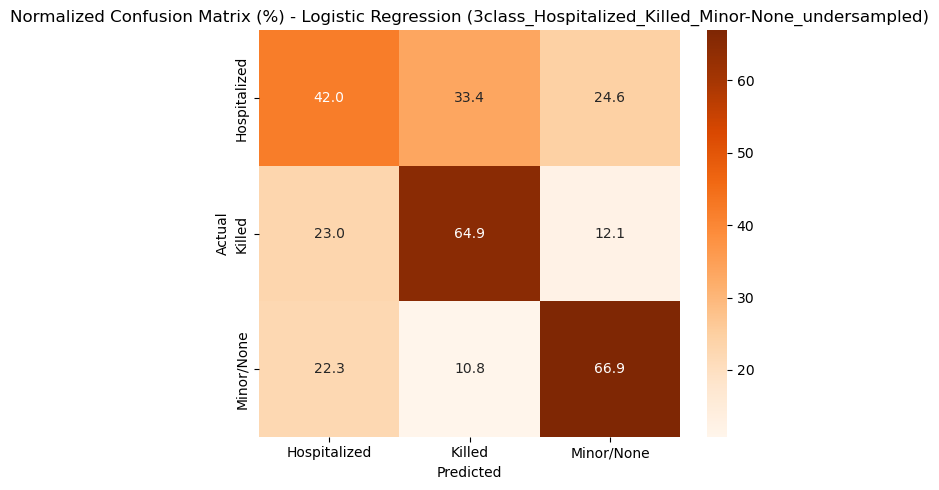


🔍 Tuning model: Decision Tree (3class_Hospitalized_Killed_Minor-None_undersampled)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Best parameters for Decision Tree (3class_Hospitalized_Killed_Minor-None_undersampled): {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
              precision    recall  f1-score   support

Hospitalized       0.20      0.48      0.28      6143
      Killed       0.07      0.53      0.12       735
  Minor/None       0.94      0.59      0.73     37232

    accuracy                           0.57     44110
   macro avg       0.40      0.53      0.37     44110
weighted avg       0.82      0.57      0.65     44110



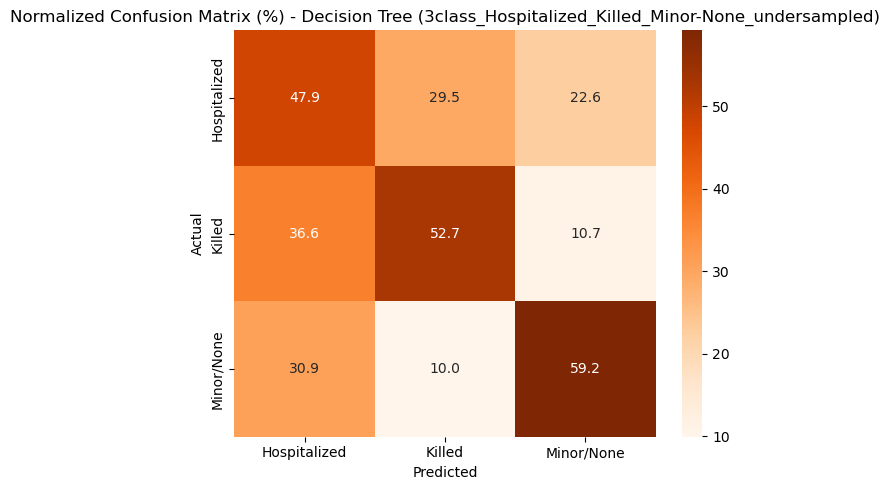

In [27]:
# ----- MODELS -----
models = {
    "Logistic Regression (3class_Hospitalized_Killed_Minor-None_undersampled)": LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs',
        multi_class='multinomial'
    ),
    "Decision Tree (3class_Hospitalized_Killed_Minor-None_undersampled)": DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    )
}

# ----- HYPERPARAMETER GRIDS -----
param_grids = {
    "Logistic Regression (3class_Hospitalized_Killed_Minor-None_undersampled)": {
        'classifier__C': [0.1, 1.0, 10.0]
    },
    "Decision Tree (3class_Hospitalized_Killed_Minor-None_undersampled)": {
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# ----- EVALUATION SETUP -----
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}

# ----- TRAIN + EVALUATE -----
for name, model in models.items():
    print(f"\n🔍 Tuning model: {name}")

    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("undersample", RandomUnderSampler(random_state=42)),
        ("classifier", model)
    ])

    search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        scoring='f1_macro',
        cv=3,
        n_jobs=1,  # Workaround for potential pickling issues
        verbose=1
    )

    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)

    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

    results[name] = {
        "model_name": name,
        "best_params": search.best_params_,
        "classification_report": report_dict,
        "confusion_matrix": cm.tolist(),
        "confusion_matrix_percent": cm_percent.tolist()
    }

    print(f"\n✅ Best parameters for {name}: {search.best_params_}")
    print(classification_report(y_test, y_pred, target_names=severity_labels, zero_division=0))

    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")

    # 🟠 Normalized confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
                xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
    ax.set_title(f"Normalized Confusion Matrix (%) - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()
    plt.close()

## RF_3_classes
**Description:**  
Standard Random Forest trained on the **full, imbalanced dataset**.  

**Trade-offs:**  
- ✅ Robust, higher accuracy than single trees.  
- ✅ Handles multiclass problems well.  
- ❌ Skewed predictions toward majority class.  
- ❌ Computationally heavier than DT/LR.  


## RF_undersampled_3_classes
**Description:**  
Random Forest trained on an **undersampled dataset** to balance across three severity classes.  

**Trade-offs:**  
- ✅ Better recall for minority classes.  
- ✅ Simple balancing method.  
- ❌ Loss of majority-class data.  
- ❌ May reduce overall accuracy.
  

## RF_cost_sensitive_3_classes
**Description:**  
Random Forest with **misclassification costs** to penalize errors on minority classes more heavily.  

**Trade-offs:**  
- ✅ Keeps full dataset.  
- ✅ Explicitly focuses on minority cases.  
- ❌ Cost calibration is tricky.  
- ❌ May bias too strongly toward minority.  


🔍 Tuning model: Random Forest 3class_Hospitalized_Killed_Minor-None
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest 3class_Hospitalized_Killed_Minor-None: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

Hospitalized       0.38      0.48      0.42      6143
      Killed       0.23      0.13      0.17       735
  Minor/None       0.91      0.87      0.89     37232

    accuracy                           0.81     44110
   macro avg       0.50      0.49      0.49     44110
weighted avg       0.82      0.81      0.81     44110



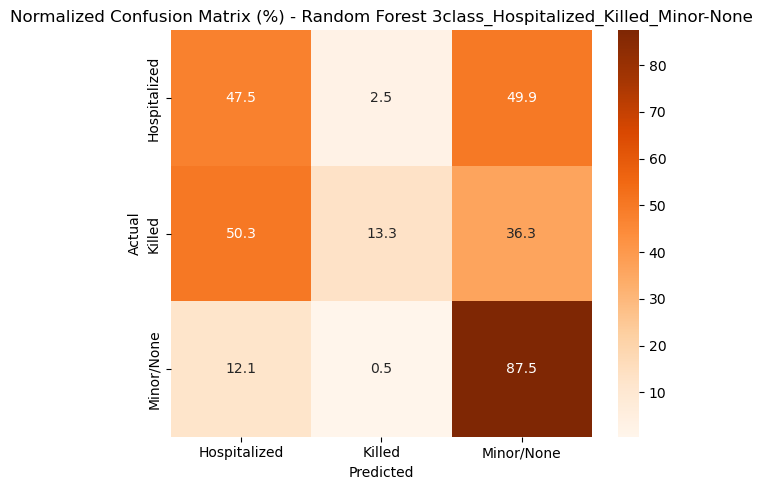

In [28]:
# ----- MODEL -----
model_name = "Random Forest 3class_Hospitalized_Killed_Minor-None"
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# ----- HYPERPARAMETER GRID -----
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# ----- EVALUATION SETUP -----
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}


# ----- PIPELINE -----
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# ----- GRID SEARCH -----
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# ----- EVALUATION -----
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, target_names=severity_labels, zero_division=0))

safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")


# 🟠 Normalized confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


🔍 Tuning model: Random Forest 3class_Hospitalized_Killed_Minor-None_undersampled
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest 3class_Hospitalized_Killed_Minor-None_undersampled: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

Hospitalized       0.23      0.43      0.30      6143
      Killed       0.07      0.67      0.13       735
  Minor/None       0.94      0.65      0.77     37232

    accuracy                           0.62     44110
   macro avg       0.42      0.59      0.40     44110
weighted avg       0.83      0.62      0.70     44110



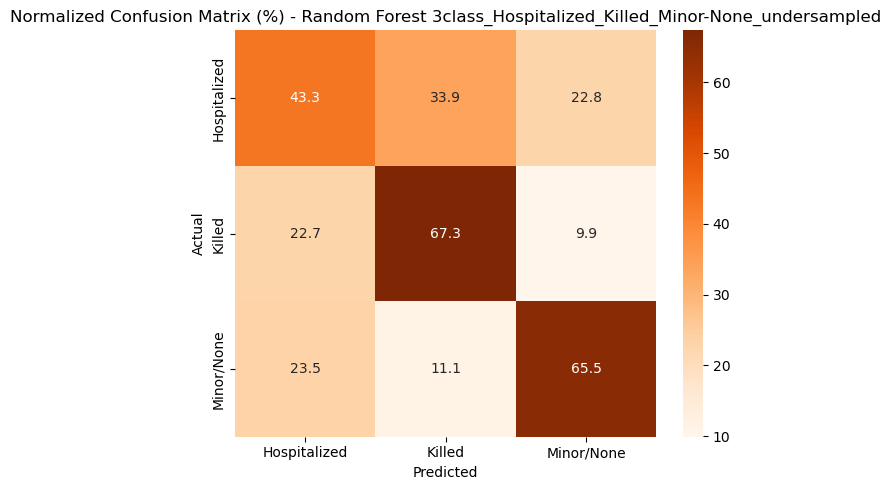

In [35]:
from imblearn.pipeline import Pipeline

# Define model
model_name = "Random Forest 3class_Hospitalized_Killed_Minor-None_undersampled"
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Evaluation setup
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}

# Build pipeline with undersampling
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("undersampler", RandomUnderSampler(random_state=42)),
    ("classifier", model)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, target_names=severity_labels, zero_division=0))

safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")


# 🟠 Normalized confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()



🔍 Tuning model: Random Forest 3class_Hospitalized_Killed_Minor-None_cost_sensitive
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest 3class_Hospitalized_Killed_Minor-None_cost_sensitive: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

Hospitalized       0.49      0.30      0.37      6143
      Killed       0.23      0.15      0.18       735
  Minor/None       0.89      0.95      0.92     37232

    accuracy                           0.85     44110
   macro avg       0.53      0.46      0.49     44110
weighted avg       0.82      0.85      0.83     44110



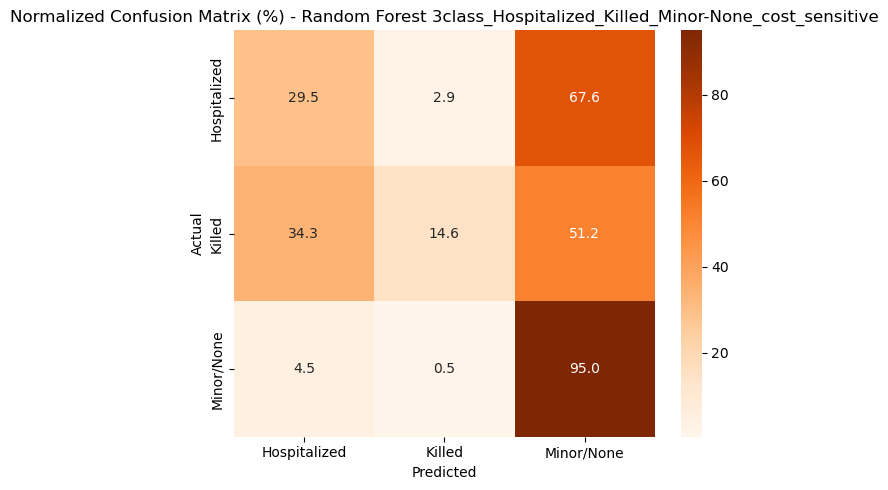

In [36]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline 

# New model name
model_name = "Random Forest 3class_Hospitalized_Killed_Minor-None_cost_sensitive"

# Cost-sensitive model
model = RandomForestClassifier(
    random_state=42,
    class_weight={0:3, 1:25, 2:1},
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Evaluation setup
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}


# Pipeline WITHOUT undersampling
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,  # use 1 to avoid pickling issues
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, target_names=severity_labels, zero_division=0))


# 🟠 Normalized confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## BalancedBagging_RF_3_classes
**Description:**  
Balanced bagging ensemble using **Random Forests as base learners**. Each trained on balanced resampled datasets.  

**Trade-offs:**  
- ✅ Combines bagging stability with Random Forest strength.  
- ✅ Improves recall on minority classes.  
- ❌ Higher computational cost.  
- ❌ May reduce precision on majority class.  


🔍 Tuning model: BalancedBagging_RF_3class_Hospitalized_Killed_Minor-None
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✅ Best parameters for BalancedBagging_RF_3class_Hospitalized_Killed_Minor-None: {'classifier__estimator__max_depth': 20, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.25      0.53      0.34      6143
           1       0.09      0.57      0.16       735
           2       0.95      0.67      0.79     37232

    accuracy                           0.65     44110
   macro avg       0.43      0.59      0.43     44110
weighted avg       0.83      0.65      0.71     44110



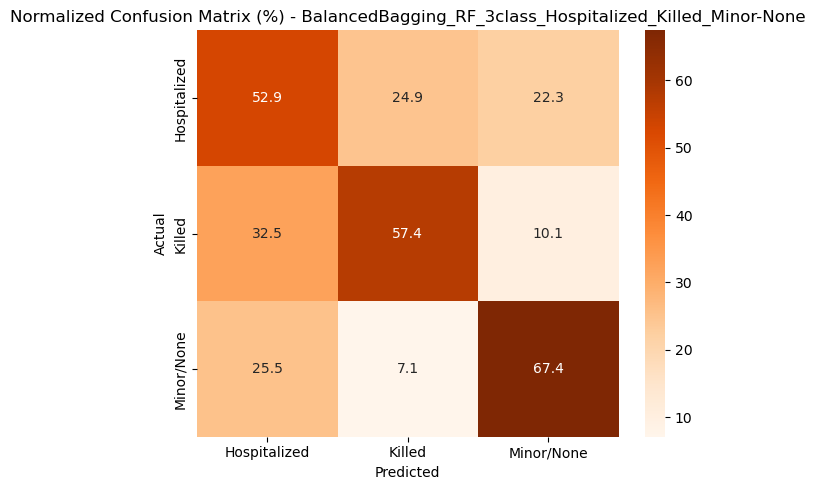

In [37]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

model_name = "BalancedBagging_RF_3class_Hospitalized_Killed_Minor-None"
base_estimator = RandomForestClassifier(n_jobs=-1, random_state=42)

bbc = BalancedBaggingClassifier(
    estimator=base_estimator,
    sampling_strategy="auto",
    replacement=False,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "classifier__estimator__n_estimators": [100],
    "classifier__estimator__max_depth": [10, 20],
    "classifier__estimator__min_samples_split": [2, 5]
}

severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}

# ------------------------
# 🧪 Pipeline + Grid Search
# ------------------------
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", bbc)
])

print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# ------------------------
# 📈 Evaluation
# ------------------------
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))


# ------------------------
# 🟠 Normalized Confusion Matrix
# ------------------------
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## BalancedRandomForest_3_classes
**Description:**  
Random Forest variant where each tree is built on a **balanced bootstrap sample** for three classes.  

**Trade-offs:**  
- ✅ Stronger recall for minority classes.  
- ✅ More stable than plain undersampling.  
- ❌ Reduced overall precision.  
- ❌ More expensive to train.


🔍 Tuning model: BalancedRandomForest_3class_Hospitalized_Killed_Minor-None
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for BalancedRandomForest_3class_Hospitalized_Killed_Minor-None: {'classifier__max_depth': None, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.26      0.58      0.36      6143
           1       0.10      0.50      0.17       735
           2       0.95      0.69      0.79     37232

    accuracy                           0.67     44110
   macro avg       0.44      0.59      0.44     44110
weighted avg       0.84      0.67      0.72     44110



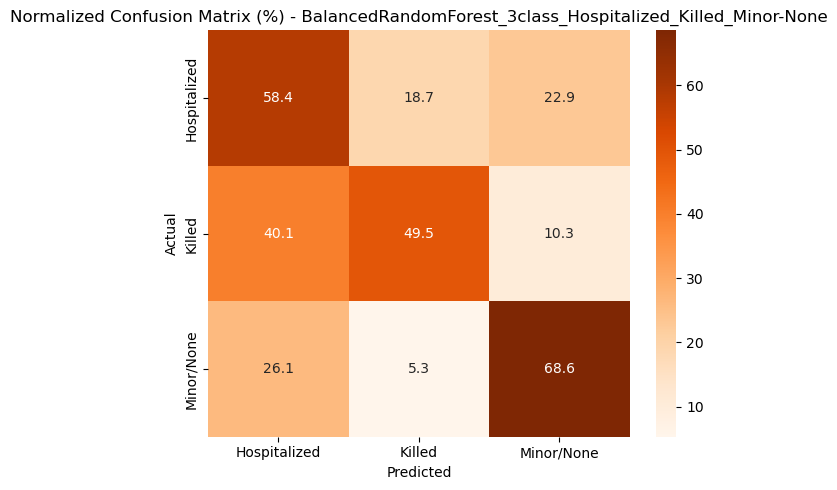

In [38]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os


model_name = "BalancedRandomForest_3class_Hospitalized_Killed_Minor-None"

# Define model
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 5]
}

severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}


# Pipeline with preprocessing
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", brf)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))


# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## SMOTETomek_RF_3_classes
**Description:**  
Random Forest trained on data rebalanced with **SMOTE (oversampling) + Tomek Links (undersampling)**.  

**Trade-offs:**  
- ✅ Preserves more minority-class information.  
- ✅ Reduces overlap/noise with Tomek Links.  
- ❌ SMOTE may create noisy synthetic samples.  
- ❌ Higher preprocessing cost.  


🔍 Tuning model: SMOTETomek_RF_3class_FAST
Fitting 3 folds for each of 4 candidates, totalling 12 fits


  File "C:\Users\jl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jl\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jl\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\jl\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



✅ Best parameters for SMOTETomek_RF_3class_FAST: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__max_depth': 10}
              precision    recall  f1-score   support

           0       0.32      0.47      0.38      6143
           1       0.14      0.20      0.16       735
           2       0.91      0.83      0.87     37232

    accuracy                           0.77     44110
   macro avg       0.45      0.50      0.47     44110
weighted avg       0.81      0.77      0.79     44110



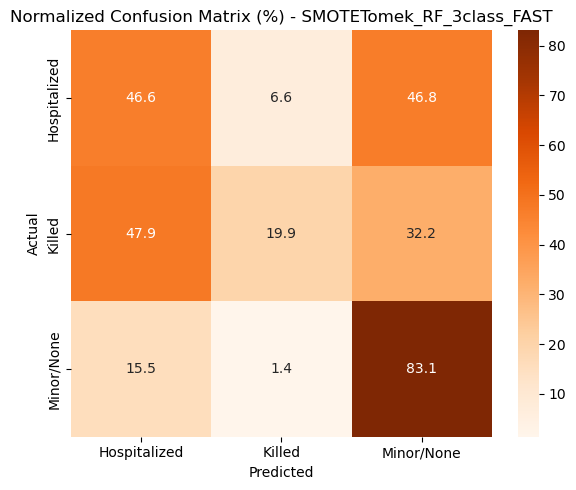

In [39]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os


# Subsample for speed 
X_train_small = X_train.sample(20000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

model_name = "SMOTETomek_RF_3class_FAST"
smote_tomek = SMOTETomek(random_state=42)
model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}


# ✅ Fast pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("smote_tomek", smote_tomek),
    ("classifier", model)
])

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=4,  # Try 4 random combos
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1,
    random_state=42
)

print(f"\n🔍 Tuning model: {model_name}")
search.fit(X_train_small, y_train_small)
y_pred = search.predict(X_test)

# 📊 Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))


# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## RUSBoost_RF_3_classes
**Description:**  
Ensemble method combining **Random UnderSampling (RUS) with boosting**, using Random Forests as base learners.  

**Trade-offs:**  
- ✅ Balances data while boosting performance.  
- ✅ Good recall for minority classes.  
- ❌ Undersampling still discards data.  
- ❌ More complex than standard RF.


🔍 Tuning model: RUSBoost_RF_3class_FULL
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✅ Best parameters for RUSBoost_RF_3class_FULL: {'classifier__estimator__max_depth': 20, 'classifier__estimator__min_samples_split': 5, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.24      0.55      0.34      6143
           1       0.10      0.44      0.16       735
           2       0.93      0.67      0.78     37232

    accuracy                           0.65     44110
   macro avg       0.42      0.55      0.43     44110
weighted avg       0.82      0.65      0.71     44110



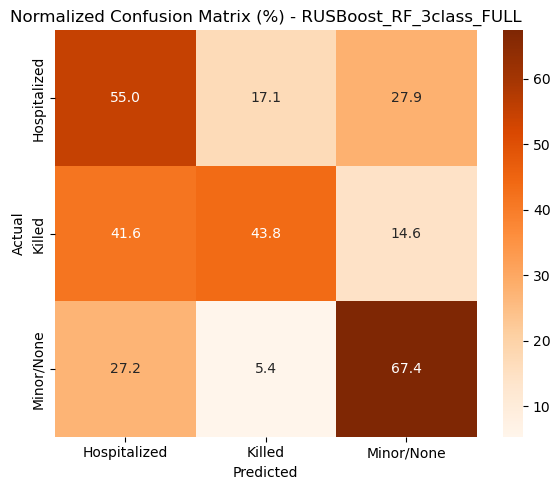

In [40]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline

# 🔧 Setup
model_name = "RUSBoost_RF_3class_FULL"
severity_labels = ["Hospitalized", "Killed", "Minor/None"]

# 🎯 Base model
base_estimator = DecisionTreeClassifier(random_state=42)

rusboost = RUSBoostClassifier(
    estimator=base_estimator,
    random_state=42,
    n_estimators=100
)

# 🔍 GridSearch parameters
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__estimator__max_depth': [10, 20],
    'classifier__estimator__min_samples_split': [2, 5]
}

# 🧱 Pipeline with preprocessor
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rusboost)
])

# 🔍 GridSearchCV
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

print(f"\n🔍 Tuning model: {model_name}")
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# 📈 Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))


# 🎨 Normalized Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## LightGBM_Balanced_3_classes
**Description:**  
LightGBM gradient boosting with **balanced class weights** for three-class severity prediction.  

**Trade-offs:**  
- ✅ Fast and memory-efficient boosting.  
- ✅ Handles imbalance via weighting.  
- ❌ Can overfit small classes.  
- ❌ Requires careful tuning of weights and learning rate.


🔍 Tuning model: LightGBM_3class_Balanced
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 176438, number of used features: 81
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

✅ Best parameters for LightGBM_3class_Balanced: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.26      0.53      0.35      6143
           1       0.09      0.57      0.16       735
           2       0.95      0.69      0.80     37232

    accuracy       

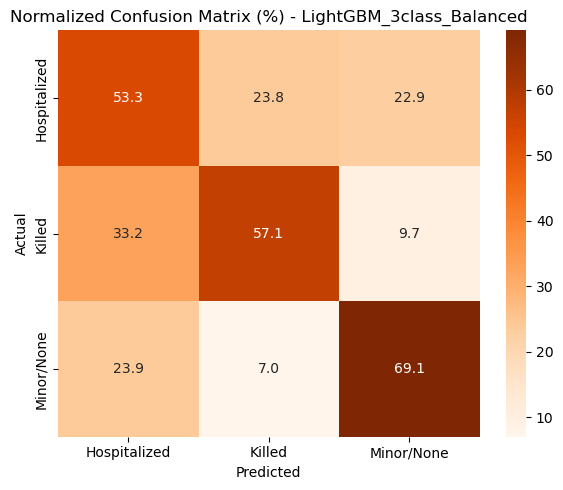

In [41]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# ⚙️ Setup
model_name = "LightGBM_3class_Balanced"
severity_labels = ["Hospitalized", "Killed", "Minor/None"]


# ⚙️ LightGBM with class weights
lgbm = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 🔍 GridSearch space
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__learning_rate': [0.05, 0.1]
}

# 🔧 Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", lgbm)
])

# 🔍 Grid Search
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print(f"\n🔍 Tuning model: {model_name}")
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# 📊 Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## CatBoost_Balanced_3_classes
**Description:**  
CatBoost gradient boosting model with **balanced class weights**, effective for categorical features.  

**Trade-offs:**  
- ✅ Excellent handling of categorical data.  
- ✅ Resistant to overfitting.  
- ❌ Training is slower than LightGBM.  
- ❌ Weights tuning is critical.  



🔍 Tuning model: CatBoost_3class_Balanced
Fitting 3 folds for each of 2 candidates, totalling 6 fits

✅ Best parameters for CatBoost_3class_Balanced: {'classifier__depth': 10, 'classifier__iterations': 100, 'classifier__learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.26      0.55      0.36      6143
           1       0.10      0.53      0.17       735
           2       0.94      0.69      0.80     37232

    accuracy                           0.67     44110
   macro avg       0.44      0.59      0.44     44110
weighted avg       0.84      0.67      0.73     44110



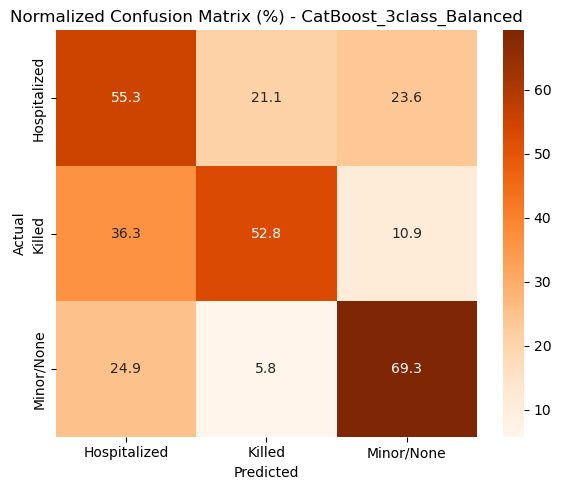

In [42]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# ⚙️ Setup
model_name = "CatBoost_3class_Balanced"
severity_labels = ["Hospitalized", "Killed", "Minor/None"]


# 📊 Estimate class weights using sklearn's compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# 🐈 CatBoost Model
cat = CatBoostClassifier(
    loss_function='MultiClass',
    class_weights=class_weights,
    verbose=0,
    random_state=42
)

# 🔍 GridSearch space (small for speed)
param_grid = {
    'classifier__iterations': [100],
    'classifier__depth': [6, 10],
    'classifier__learning_rate': [0.1]
}

# 🔧 Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", cat)
])

# 🔍 Grid Search
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print(f"\n🔍 Tuning model: {model_name}")
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# 📊 Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))


# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## DL_3_classes
**Description:**  
Deep Learning model (e.g., dense neural network) for three-class severity prediction.  

**Trade-offs:**  
- ✅ Can capture complex nonlinear relationships.  
- ✅ Scales well with large feature sets.  
- ❌ Requires more data and tuning.  
- ❌ Less interpretable compared to tree models. 

Epoch 1/20
552/552 - 4s - 7ms/step - accuracy: 0.6117 - loss: 0.9225 - val_accuracy: 0.5860 - val_loss: 0.9017
Epoch 2/20
552/552 - 2s - 3ms/step - accuracy: 0.6221 - loss: 0.8717 - val_accuracy: 0.6206 - val_loss: 0.8322
Epoch 3/20
552/552 - 2s - 3ms/step - accuracy: 0.6288 - loss: 0.8553 - val_accuracy: 0.5954 - val_loss: 0.8715
Epoch 4/20
552/552 - 2s - 3ms/step - accuracy: 0.6286 - loss: 0.8449 - val_accuracy: 0.5727 - val_loss: 0.9025
Epoch 5/20
552/552 - 2s - 3ms/step - accuracy: 0.6326 - loss: 0.8359 - val_accuracy: 0.6502 - val_loss: 0.7520
Epoch 6/20
552/552 - 2s - 3ms/step - accuracy: 0.6353 - loss: 0.8228 - val_accuracy: 0.6169 - val_loss: 0.7962
Epoch 7/20
552/552 - 2s - 3ms/step - accuracy: 0.6319 - loss: 0.8155 - val_accuracy: 0.6259 - val_loss: 0.7642
Epoch 8/20
552/552 - 2s - 3ms/step - accuracy: 0.6362 - loss: 0.8084 - val_accuracy: 0.6103 - val_loss: 0.7916
Epoch 9/20
552/552 - 2s - 4ms/step - accuracy: 0.6380 - loss: 0.8009 - val_accuracy: 0.6378 - val_loss: 0.7591
E

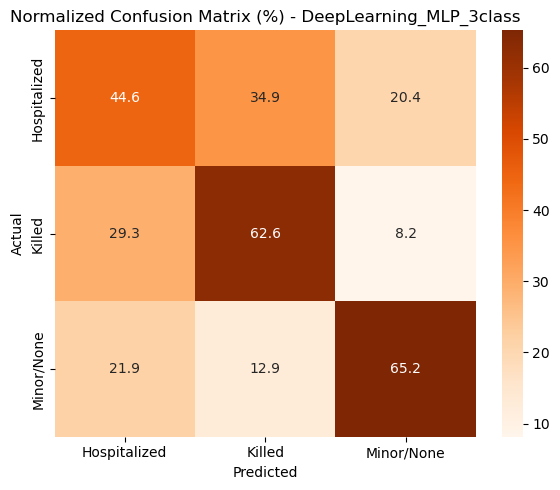

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import os, json, joblib

# 🔧 Setup
model_name = "DeepLearning_MLP_3class"
severity_labels = ["Hospitalized", "Killed", "Minor/None"]

# 🧪 Transform X using preprocessor
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# 🔢 Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
n_classes = len(np.unique(y_train_enc))

# ⚖️ Compute class weights
weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = dict(enumerate(weights))

# 🧠 Build MLP
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🚀 Train
history = model.fit(
    X_train_proc, y_train_enc,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=2
)

# 📊 Predict
y_pred_prob = model.predict(X_test_proc)
y_pred = np.argmax(y_pred_prob, axis=1)

# 📈 Evaluation
report_dict = classification_report(y_test_enc, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test_enc, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

print("\n📋 Classification Report:")
print(classification_report(y_test_enc, y_pred, zero_division=0))

# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


## XGBoost_3_classes
**Description:**  
XGBoost trained on the **full, imbalanced dataset** for 3-class prediction.  

**Trade-offs:**  
- ✅ High predictive power.  
- ✅ Strong multiclass performance.  
- ❌ Bias toward majority unless balanced.  
- ❌ Computationally intensive.



## XGBoost_weighted_3_classes
**Description:**  
XGBoost with **class-weighted loss** to handle imbalance across three classes.  

**Trade-offs:**  
- ✅ High predictive performance.  
- ✅ Flexible imbalance handling via weights.  
- ❌ Computationally expensive.  
- ❌ Needs careful hyperparameter tuning.  


🔍 Tuning model: XGBoost (RandomizedSearch, No Undersampling, 3class_Hospitalized_Killed_Minor-None) with randomized search
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best parameters for XGBoost (RandomizedSearch, No Undersampling, 3class_Hospitalized_Killed_Minor-None): {'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 1.0}
              precision    recall  f1-score   support

           0       0.55      0.17      0.26      6143
           1       0.50      0.04      0.07       735
           2       0.87      0.98      0.92     37232

    accuracy                           0.85     44110
   macro avg       0.64      0.40      0.42     44110
weighted avg       0.82      0.85      0.81     44110



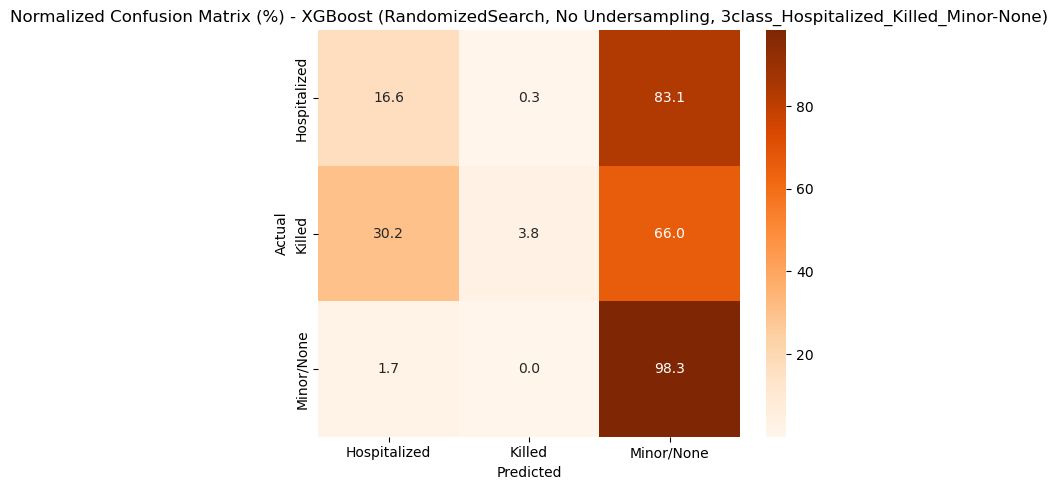

In [44]:

model_name = "XGBoost (RandomizedSearch, No Undersampling, 3class_Hospitalized_Killed_Minor-None)"
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

# Simplified hyperparameter search space
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

severity_labels = label_encoder.classes_.tolist()
results = {}
os.makedirs("heatmaps", exist_ok=True)

# Randomized search
print(f"\n🔍 Tuning model: {model_name} with randomized search")
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring='f1_macro',
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
y_pred = search.best_estimator_.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))


# 🟠 Normalized heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges", xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


In [45]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier


# Model name
model_name = "XGBoost_3class_Hospitalized_Killed_Minor-None_weighted"

# Compute sample weights
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# XGBoost model
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6],
    'classifier__learning_rate': [0.1],
    'classifier__subsample': [1.0],
    'classifier__colsample_bytree': [0.8]
}

# Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Output setup
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
results = {}


# Grid search with sample weights
print(f"\n🔍 Tuning model: {model_name} with class weights")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=1,
    refit=True
)

search.fit(X_train, y_train, classifier__sample_weight=sample_weights)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))


# 🟠 Normalized confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges", xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.close()



🔍 Tuning model: XGBoost_3class_Hospitalized_Killed_Minor-None_weighted with class weights
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✅ Best parameters for XGBoost_3class_Hospitalized_Killed_Minor-None_weighted: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
              precision    recall  f1-score   support

           0       0.26      0.53      0.35      6143
           1       0.09      0.58      0.16       735
           2       0.95      0.70      0.80     37232

    accuracy                           0.67     44110
   macro avg       0.43      0.60      0.44     44110
weighted avg       0.84      0.67      0.73     44110



## RF_ADASYN_3_classes
**Description:**  
Random Forest trained on **ADASYN-oversampled dataset** for better class balance.  

**Trade-offs:**  
- ✅ Improves recall for minority classes.  
- ✅ Retains full dataset + synthetic minority boost.  
- ❌ Sensitive to noise in generated samples.  
- ❌ Longer training with larger synthetic set.  



🔍 Tuning model: Random Forest 3class_Hospitalized_Killed_Minor-None_ADASYN
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest 3class_Hospitalized_Killed_Minor-None_ADASYN: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

Hospitalized       0.40      0.38      0.39     30712
      Killed       0.21      0.16      0.18      3676
  Minor/None       0.90      0.91      0.90    186160

    accuracy                           0.82    220548
   macro avg       0.50      0.48      0.49    220548
weighted avg       0.82      0.82      0.82    220548



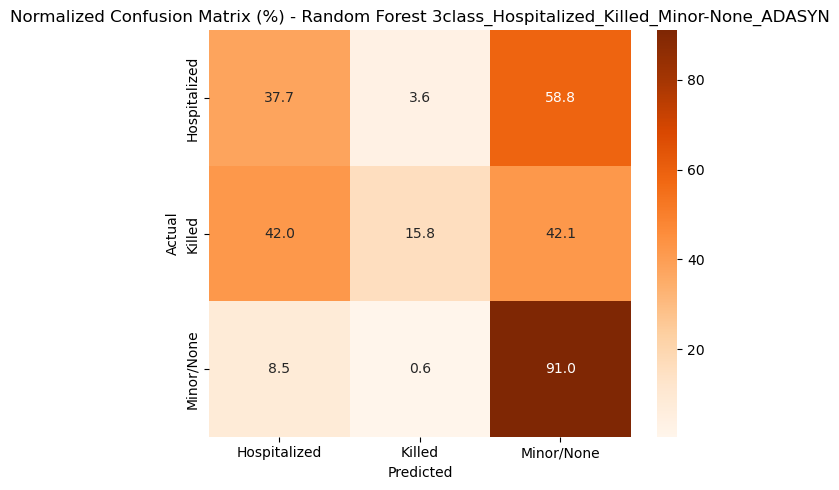

In [47]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix


# ----- CONFIGURATION -----
model_name = "Random Forest 3class_Hospitalized_Killed_Minor-None_ADASYN"
safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
top_n = 20
results = {}


# ----- MODEL + PARAM GRID -----
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# ----- PIPELINE with ADASYN -----
pipeline = Pipeline([
    ("preprocessor", preprocessor),    
    ("oversampler", ADASYN(random_state=42)),
    ("classifier", model)
])

# ----- GRID SEARCH -----
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X, y)  

# ----- CROSS-VALIDATED PREDICTIONS -----
best_pipeline = search.best_estimator_
y_pred = cross_val_predict(best_pipeline, X, y, cv=5, n_jobs=1)

# ----- EVALUATION -----
report_dict = classification_report(y, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y, y_pred, target_names=severity_labels, zero_division=0))



fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## LightGBM_ADASYN_3_classes
**Description:**  
LightGBM trained on data resampled with **ADASYN (Adaptive Synthetic Sampling)** to oversample minority classes.  

**Trade-offs:**  
- ✅ Generates adaptive synthetic samples for better balance.  
- ✅ Fast and efficient boosting.  
- ❌ Synthetic data may introduce noise.  
- ❌ Needs tuning of ADASYN ratio.  


🔍 Tuning model: LightGBM 3class_Hospitalized_Killed_Minor-None_ADASYN
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20654
[LightGBM] [Info] Number of data points in the train set: 375116, number of used features: 81
[LightGBM] [Info] Start training from score -1.081357
[LightGBM] [Info] Start training from score -1.108608
[LightGBM] [Info] Start training from score -1.106099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20654
[LightGBM] [Info] Number of data points in the train set: 376073, number of used features: 8

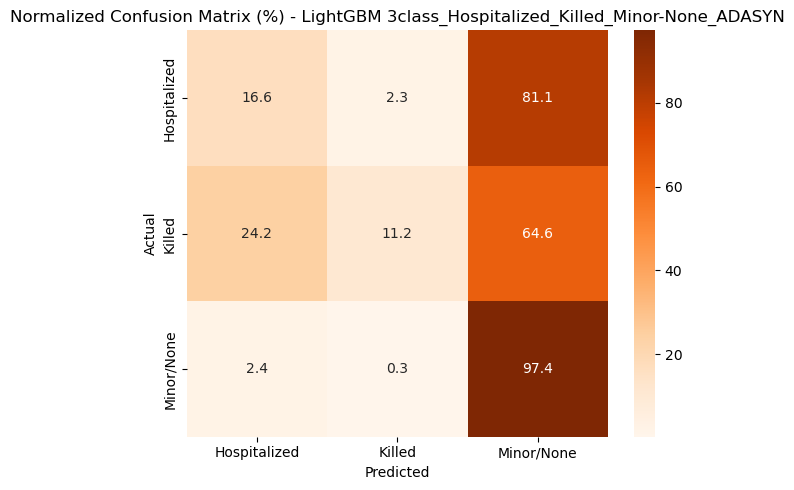

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier

# ----- CONFIGURATION -----
model_name = "LightGBM 3class_Hospitalized_Killed_Minor-None_ADASYN"
safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
top_n = 20
results = {}


# ----- MODEL + PARAM GRID -----
model = LGBMClassifier(objective='multiclass', random_state=42, n_jobs=-1)
param_grid = {
    'classifier__num_leaves': [31],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [100]
}

# ----- PIPELINE with ADASYN -----
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("oversampler", ADASYN(random_state=42)),
    ("classifier", model)
])

# ----- GRID SEARCH -----
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X, y)

# ----- CROSS-VALIDATED PREDICTIONS -----
best_pipeline = search.best_estimator_
y_pred = cross_val_predict(best_pipeline, X, y, cv=5, n_jobs=1)

# ----- EVALUATION -----
report_dict = classification_report(y, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y, y_pred, target_names=severity_labels, zero_division=0))


fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## BalancedBagging_3_classes
**Description:**  
Bagging ensemble of decision trees, each trained on **balanced bootstrap samples** for three classes.  

**Trade-offs:**  
- ✅ Improves recall on minority classes.  
- ✅ Reduces overfitting compared to a single tree.  
- ❌ Lower raw accuracy than boosting methods.  
- ❌ More computationally demanding than a single DT.  


🔍 Training model: BalancedBagging 3class_Hospitalized_Killed_Minor-None

✅ Evaluation for BalancedBagging 3class_Hospitalized_Killed_Minor-None
              precision    recall  f1-score   support

Hospitalized       0.23      0.46      0.31     30712
      Killed       0.07      0.62      0.13      3676
  Minor/None       0.94      0.64      0.76    186160

    accuracy                           0.61    220548
   macro avg       0.41      0.58      0.40    220548
weighted avg       0.83      0.61      0.69    220548



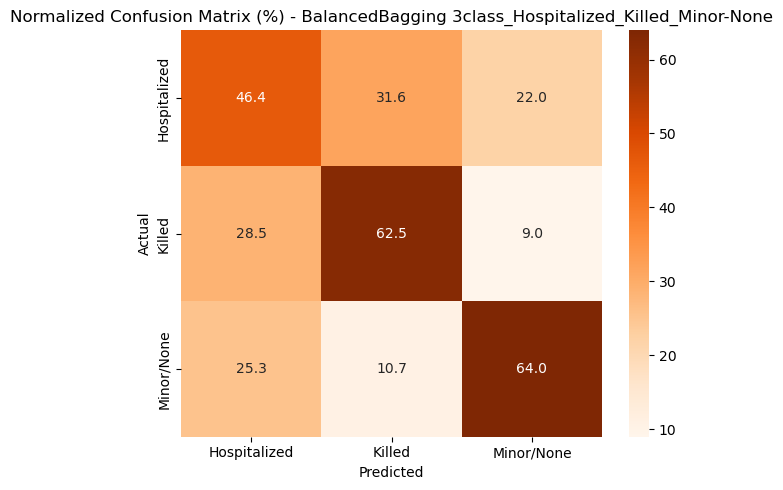

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline

# ----- CONFIGURATION -----
model_name = "BalancedBagging 3class_Hospitalized_Killed_Minor-None"
safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
severity_labels = ["Hospitalized", "Killed", "Minor/None"]
top_n = 20
results = {}


# ----- BASE ESTIMATOR -----
base_model = DecisionTreeClassifier(
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

bbc = BalancedBaggingClassifier(
    estimator=base_model,
    sampling_strategy='auto',
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# ----- PIPELINE -----
pipeline = Pipeline([
    ("preprocessor", preprocessor),  
    ("classifier", bbc)
])

# ----- CROSS-VALIDATED PREDICTION -----
print(f"\n🔍 Training model: {model_name}")
y_pred = cross_val_predict(pipeline, X, y, cv=5, n_jobs=1)

# ----- EVALUATION -----
report_dict = classification_report(y, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Evaluation for {model_name}")
print(classification_report(y, y_pred, target_names=severity_labels, zero_division=0))

# ----- PLOT CONFUSION MATRICES -----

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()
